In [262]:
#Upload Data
import pandas as pd
datafile = "/Users/justinpassek/Downloads/scraped_data/scraped_listings.csv"
scraped_listings = pd.read_csv(datafile,engine='python')
#print(scraped_listings)

datafile = "/Users/justinpassek/Downloads/scraped_data/scraped_data.csv"
scraped_data = pd.read_csv(datafile,engine='python')
#print(scraped_data)

In [263]:
scraped_data.price.describe()
scraped_listings.head()
scraped_data.head()

,scraping_id,scraped_date,date,price,available
0,2,2018-03-15,2018-04-01,250,1
1,2,2018-03-15,2018-04-02,115,1
2,2,2018-03-15,2018-04-03,115,1
3,2,2018-03-15,2018-04-04,115,1
4,2,2018-03-15,2018-04-05,150,0


      scraping_id  days_on_site  available  booked_rate
0               2            61         35     0.573770
1               3            61         33     0.540984
2               4            61         14     0.229508
3               5            61         41     0.672131
4               6            61          3     0.049180
...           ...           ...        ...          ...
4107     23309702            61         27     0.442623
4108     23310204            61         44     0.721311
4109     23310561            61         51     0.836066
4110     23318845            61         61     1.000000
4111     23326501            61         61     1.000000

[4112 rows x 4 columns]


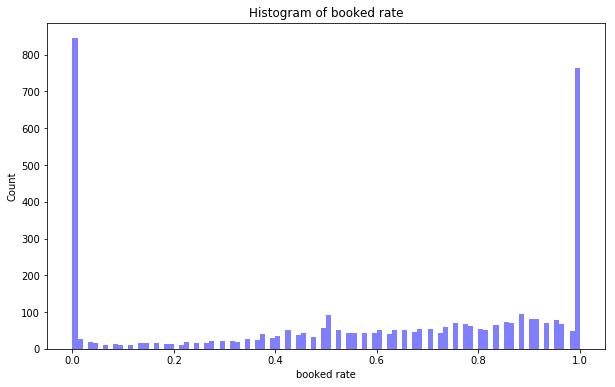

      scraping_id  days_on_site  available  booked_rate
0              14            61          0          0.0
1              15            61          0          0.0
2              40            61          0          0.0
3              57            61          0          0.0
4              58            61          0          0.0
...           ...           ...        ...          ...
1605     23272407            61         61          1.0
1606     23285671            61         61          1.0
1607     23287143            61         61          1.0
1608     23318845            61         61          1.0
1609     23326501            61         61          1.0

[1610 rows x 4 columns]


In [264]:
## FINDING PROPERTIES THAT ARE UNRELIABLE DUE TO OWNER BLOCK

#Slice data set for earliest data
df_blocked_prop_id = scraped_data[scraped_data['scraped_date'] == '2018-03-15']

#Group by property
df_blocked_prop_id = df_blocked_prop_id.groupby('scraping_id').agg({'date':'count',
                                                              'available': 'sum',}
                                                            ).reset_index()
#Rename                                                              
df_blocked_prop_id.rename(columns={"date":"days_on_site"},
                       inplace=True)

#Look at distribution of book rate and identify anomalies
df_blocked_prop_id['booked_rate'] = df_blocked_prop_id['available'] / df_blocked_prop_id['days_on_site']
print(df_blocked_prop_id)

import matplotlib.pyplot as plt
%matplotlib inline
num_bins = 100
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_blocked_prop_id['booked_rate'], num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('booked rate')
plt.ylabel('Count')
plt.title('Histogram of booked rate')
plt.show()

#Find properties that are either 100% booked (indicating owner block) or 0% booked (indicating lack of owner response)
df_blocked_prop_id_0 = df_blocked_prop_id[df_blocked_prop_id['booked_rate'] == 0]
df_blocked_prop_id_1 = df_blocked_prop_id[df_blocked_prop_id['booked_rate'] == 1]

df_blocked_prop_id = df_blocked_prop_id_0.append(df_blocked_prop_id_1, ignore_index=True)
print(df_blocked_prop_id)

In [265]:
import numpy as np

#Finding revenue generated and missed
scraped_data['rev_generated'] = np.where(scraped_data.available == 1, 0, scraped_data.price)
scraped_data['rev_missed'] = np.where(scraped_data.available == 0, 0, scraped_data.price)
scraped_data.head()

,scraping_id,scraped_date,date,price,available,rev_generated,rev_missed
0,2,2018-03-15,2018-04-01,250,1,0,250
1,2,2018-03-15,2018-04-02,115,1,0,115
2,2,2018-03-15,2018-04-03,115,1,0,115
3,2,2018-03-15,2018-04-04,115,1,0,115
4,2,2018-03-15,2018-04-05,150,0,150,0


In [266]:
## GENERATING PROPERTY METRICS

#Availability metrics are derived from availability on the scraped day to reduce error
df_scraped_data = scraped_data[scraped_data['date'] == scraped_data['scraped_date']]
df_scraped_data['price_b'] = df_scraped_data['price']

#Aggregating on property id
df_scraped_data = df_scraped_data.groupby('scraping_id').agg({'date':'count',
                                                              'rev_generated': 'sum',
                                                              'rev_missed':'sum', 
                                                              'price_b':'sum',
                                                              'available': 'sum', 
                                                              'price':'mean'}
                                                            ).reset_index()

df_scraped_data.rename(columns={"date":"days_on_site",
                               "price":"average_price",
                               "price_b":"total_offered_value"},
                       inplace=True)

df_scraped_data['booked_days'] = df_scraped_data['days_on_site'] - df_scraped_data['available'].astype(int)
df_scraped_data['average_booked_price'] = df_scraped_data['rev_generated']/df_scraped_data['booked_days']
df_scraped_data['average_unbooked_price'] = df_scraped_data['rev_missed']/df_scraped_data['available']
df_scraped_data['booked_unbooked_diff'] = df_scraped_data['average_booked_price'] - df_scraped_data['average_unbooked_price']
df_scraped_data['booked_rate'] = df_scraped_data['booked_days']/df_scraped_data['days_on_site']
df_scraped_data = df_scraped_data.round({'average_price':2,
                       'average_booked_price': 2,
                       'average_unbooked_price': 2,
                       'booked_unbooked_diff':2,
                       'booked_rate':2})

df_scraped_data.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,scraping_id,days_on_site,rev_generated,rev_missed,total_offered_value,available,average_price,booked_days,average_booked_price,average_unbooked_price,booked_unbooked_diff,booked_rate
0,2,60,4823,2200,7023,19,117.05,41,117.63,115.79,1.84,0.68
1,3,60,3664,1018,4682,14,78.03,46,79.65,72.71,6.94,0.77
2,4,59,5421,0,5421,0,91.88,59,91.88,NaN,NaN,1.00
3,5,59,4250,1311,5561,16,94.25,43,98.84,81.94,16.90,0.73
4,6,60,3983,840,4823,12,80.38,48,82.98,70.00,12.98,0.80


In [267]:
#Joining tables on property id
master_df = scraped_listings.join(df_scraped_data.set_index('scraping_id'), on='scraping_id')
master_df.head()

,scraping_id,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,...,rev_generated,rev_missed,total_offered_value,available,average_price,booked_days,average_booked_price,average_unbooked_price,booked_unbooked_diff,booked_rate
0,2,https://www.airbnb.com/rooms/17720788,Scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2,...,4823.0,2200.0,7023.0,19.0,117.05,41.0,117.63,115.79,1.84,0.68
1,3,https://www.airbnb.com/rooms/4400911,Scottsdale,-111.898977,33.463182,https://maps.google.com/maps?q=33.463182488027...,Upscale Townhouse South Scottsdale,4,1.5,2,...,3664.0,1018.0,4682.0,14.0,78.03,46.0,79.65,72.71,6.94,0.77
2,4,https://www.airbnb.com/rooms/19748678,Scottsdale,-111.957684,33.607810,https://maps.google.com/maps?q=33.607809726520...,North Scottsdale/ PV Private Guest House w/pool,4,1.0,0,...,5421.0,0.0,5421.0,0.0,91.88,59.0,91.88,NaN,NaN,1.00
3,5,https://www.airbnb.com/rooms/18900365,Scottsdale,-111.915536,33.499397,https://maps.google.com/maps?q=33.499396773678...,Mountain View Paradise*Heated Pool*Spa*Gym,4,1.0,1,...,4250.0,1311.0,5561.0,16.0,94.25,43.0,98.84,81.94,16.90,0.73
4,6,https://www.airbnb.com/rooms/15808110,Scottsdale,-111.910657,33.490571,https://maps.google.com/maps?q=33.490570685645...,Modern Luxury Scottsdale Condo!,5,1.0,2,...,3983.0,840.0,4823.0,12.0,80.38,48.0,82.98,70.00,12.98,0.80


In [276]:
#Remove outliers from joined dataframe
df = master_df[~master_df['scraping_id'].isin(df_blocked_prop_id['scraping_id'])]
df.head()

,scraping_id,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,...,rev_generated,rev_missed,total_offered_value,available,average_price,booked_days,average_booked_price,average_unbooked_price,booked_unbooked_diff,booked_rate
0,2,https://www.airbnb.com/rooms/17720788,Scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2,...,4823.0,2200.0,7023.0,19.0,117.05,41.0,117.63,115.79,1.84,0.68
1,3,https://www.airbnb.com/rooms/4400911,Scottsdale,-111.898977,33.463182,https://maps.google.com/maps?q=33.463182488027...,Upscale Townhouse South Scottsdale,4,1.5,2,...,3664.0,1018.0,4682.0,14.0,78.03,46.0,79.65,72.71,6.94,0.77
2,4,https://www.airbnb.com/rooms/19748678,Scottsdale,-111.957684,33.607810,https://maps.google.com/maps?q=33.607809726520...,North Scottsdale/ PV Private Guest House w/pool,4,1.0,0,...,5421.0,0.0,5421.0,0.0,91.88,59.0,91.88,NaN,NaN,1.00
3,5,https://www.airbnb.com/rooms/18900365,Scottsdale,-111.915536,33.499397,https://maps.google.com/maps?q=33.499396773678...,Mountain View Paradise*Heated Pool*Spa*Gym,4,1.0,1,...,4250.0,1311.0,5561.0,16.0,94.25,43.0,98.84,81.94,16.90,0.73
4,6,https://www.airbnb.com/rooms/15808110,Scottsdale,-111.910657,33.490571,https://maps.google.com/maps?q=33.490570685645...,Modern Luxury Scottsdale Condo!,5,1.0,2,...,3983.0,840.0,4823.0,12.0,80.38,48.0,82.98,70.00,12.98,0.80


In [269]:
#In which month do properties appear to generate more revenue? April or May?

#Remove unreliable properties
month_scraped_data = scraped_data[~scraped_data['scraping_id'].isin(df_blocked_prop_id['scraping_id'])]
month_scraped_data = month_scraped_data[month_scraped_data['date'] == month_scraped_data['scraped_date']]
month_scraped_data['month'] = pd.DatetimeIndex(month_scraped_data['date']).month
month_scraped_data['price_b'] = month_scraped_data['price']

month_scraped_data = month_scraped_data.groupby(['scraping_id','month']).agg({'date':'count',
                                                              'rev_generated': 'sum',
                                                              'rev_missed':'sum', 
                                                              'price_b':'sum',
                                                              'available': 'sum', 
                                                              'price':'mean'
                                                                             }).reset_index()
month_scraped_data.rename(columns={"date":"days_on_site",
                               "price":"average_price",
                               "price_b":"total_offered_value"},
                       inplace=True)

month_scraped_data

,scraping_id,month,days_on_site,rev_generated,rev_missed,total_offered_value,available,average_price
0,2,4,29,2175,1280,3455,11,119.137931
1,2,5,31,2648,920,3568,8,115.096774
2,3,4,29,1983,460,2443,6,84.241379
3,3,5,31,1681,558,2239,8,72.225806
4,4,4,29,3097,0,3097,0,106.793103
...,...,...,...,...,...,...,...,...
6628,24695237,5,24,1650,0,1650,0,68.750000
6629,24696771,5,24,684,238,922,6,38.416667
6630,24704235,5,24,624,102,726,4,30.250000
6631,24707544,4,1,150,0,150,0,150.000000


In [270]:
april_scraped_data = month_scraped_data[month_scraped_data['month'] == 4]
may_scraped_data = month_scraped_data[month_scraped_data['month'] == 5]

may_scraped_data['rev_generated'].describe()

count      3871.000000
mean       4752.612503
std       25074.827628
min           0.000000
25%        1282.500000
50%        2344.000000
75%        4423.500000
max      750000.000000
Name: rev_generated, dtype: float64

In [271]:
may_scraped_data['rev_missed'].describe()

count      3871.000000
mean       1613.149832
std        3984.333369
min           0.000000
25%           0.000000
50%         300.000000
75%        1780.000000
max      118916.000000
Name: rev_missed, dtype: float64

In [272]:
april_scraped_data['rev_generated'].describe()

count      2762.000000
mean       5997.987690
std       27359.968462
min           0.000000
25%        1802.750000
50%        3274.000000
75%        5630.250000
max      700000.000000
Name: rev_generated, dtype: float64

In [273]:
april_scraped_data['rev_missed'].describe()

count     2762.000000
mean      1539.474656
std       3412.924107
min          0.000000
25%          0.000000
50%        376.000000
75%       1621.500000
max      76720.000000
Name: rev_missed, dtype: float64

In [274]:
#Welch T-Test comparing revenue generated for April and May
from scipy import stats
stats.ttest_ind(april_scraped_data['rev_generated'],
                may_scraped_data['rev_generated'],
                equal_var = False)

Ttest_indResult(statistic=1.8916087141313993, pvalue=0.0585944882181489)

In [150]:
#How much more revenue do places with 3 bedrooms make vs. places with 2 bedrooms?

In [283]:
three_bed = df[df['bedrooms'] == 3]
two_bed = df[df['bedrooms'] == 2]

three_bed['rev_generated'].describe().apply(lambda x: format(x, 'f'))

count        745.000000
mean       15583.157047
std       105231.175004
min            0.000000
25%         3540.000000
50%         6460.000000
75%        10347.000000
max      1450000.000000
Name: rev_generated, dtype: object

In [284]:
two_bed['rev_generated'].describe()

count     1179.000000
mean      4780.965225
std       3361.444710
min          0.000000
25%       2295.000000
50%       4357.000000
75%       6494.500000
max      26525.000000
Name: rev_generated, dtype: float64

In [286]:
three_bed['rev_missed'].describe().apply(lambda x: format(x, 'f'))

count      745.000000
mean      2922.318121
std       4978.081337
min          0.000000
25%         65.000000
50%       1275.000000
75%       3821.000000
max      50000.000000
Name: rev_missed, dtype: object

In [287]:
two_bed['rev_missed'].describe()

count     1179.000000
mean      1525.368957
std       2603.958107
min          0.000000
25%          0.000000
50%        531.000000
75%       2099.000000
max      36592.000000
Name: rev_missed, dtype: float64

In [288]:
df.head()

,scraping_id,listing,city,lon,lat,mapped_location,name,capacity,bathrooms,bedrooms,...,rev_generated,rev_missed,total_offered_value,available,average_price,booked_days,average_booked_price,average_unbooked_price,booked_unbooked_diff,booked_rate
0,2,https://www.airbnb.com/rooms/17720788,Scottsdale,-111.916935,33.496566,https://maps.google.com/maps?q=33.496565678911...,Old Town Scottsdale Vacation Home & GIANTS Rental,7,2.5,2,...,4823.0,2200.0,7023.0,19.0,117.05,41.0,117.63,115.79,1.84,0.68
1,3,https://www.airbnb.com/rooms/4400911,Scottsdale,-111.898977,33.463182,https://maps.google.com/maps?q=33.463182488027...,Upscale Townhouse South Scottsdale,4,1.5,2,...,3664.0,1018.0,4682.0,14.0,78.03,46.0,79.65,72.71,6.94,0.77
2,4,https://www.airbnb.com/rooms/19748678,Scottsdale,-111.957684,33.607810,https://maps.google.com/maps?q=33.607809726520...,North Scottsdale/ PV Private Guest House w/pool,4,1.0,0,...,5421.0,0.0,5421.0,0.0,91.88,59.0,91.88,NaN,NaN,1.00
3,5,https://www.airbnb.com/rooms/18900365,Scottsdale,-111.915536,33.499397,https://maps.google.com/maps?q=33.499396773678...,Mountain View Paradise*Heated Pool*Spa*Gym,4,1.0,1,...,4250.0,1311.0,5561.0,16.0,94.25,43.0,98.84,81.94,16.90,0.73
4,6,https://www.airbnb.com/rooms/15808110,Scottsdale,-111.910657,33.490571,https://maps.google.com/maps?q=33.490570685645...,Modern Luxury Scottsdale Condo!,5,1.0,2,...,3983.0,840.0,4823.0,12.0,80.38,48.0,82.98,70.00,12.98,0.80


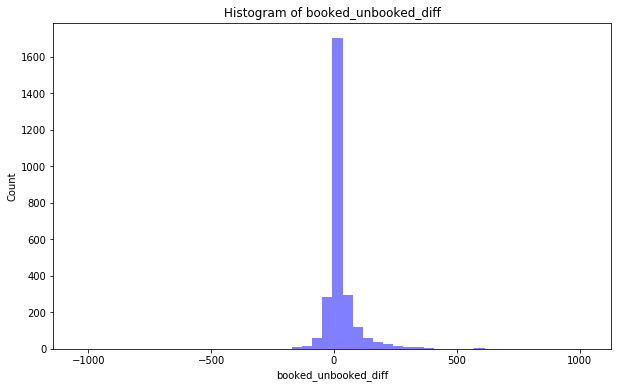

In [289]:
import matplotlib.pyplot as plt
%matplotlib inline
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df['booked_unbooked_diff'].dropna(), num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('booked_unbooked_diff')
plt.ylabel('Count')
plt.title('Histogram of booked_unbooked_diff')
plt.show()

In [290]:
df['booked_unbooked_diff'].describe()

count    2687.000000
mean       25.020275
std        85.289663
min     -1038.630000
25%         0.000000
50%         5.380000
75%        30.375000
max      1026.780000
Name: booked_unbooked_diff, dtype: float64